In [1]:
import sys
import copy
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from tqdm import tqdm

from naiad.models import EmbedPhenoDataset, EmbedPhenoModel, RecoverModel
from naiad.utils import load_naiad_data, \
                        split_data, \
                        create_lr_scheduler

In [2]:
device = (
    'cuda' if torch.cuda.is_available() else
    'mps' if torch.backends.mps.is_available() else
    'cpu'
)

pd.set_option('mode.chained_assignment', None)
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

## Prepare Data

In [3]:
data_source = 'norman' # choose one of: ['norman', 'simpson', 'horlbeck_jurkat', 'horlbeck_k562']

In [4]:
data_path = (
    '../../data/norman/norman_gamma.csv' if data_source == 'norman' else
    '../../data/simpson/simpson_gamma.csv' if data_source == 'simpson' else
    '../../data/horlbeck/horlbeck_jurkat_gamma.csv' if data_source == 'horlbeck_jurkat' else
    '../../data/horlbeck/horlbeck_k562_gamma.csv'
)

os.mkdir('results') if not os.path.exists('results') else None

pheno_pert_data = load_naiad_data(data_path)

gene_cols = [col for col in pheno_pert_data.columns if re.match(r'id\d$', col)]
all_genes = np.sort(np.unique(pheno_pert_data[gene_cols].values.flatten())).tolist()

In [5]:
def prepare_dataloaders(data, batch_size, genes):
    datasets = {split: EmbedPhenoDataset(data[split], genes) for split in data}
    dataloaders = {split: DataLoader(datasets[split], shuffle = False, batch_size = batch_size) for split in datasets}

    return dataloaders

## Train Model

In [6]:
if data_source == 'norman':
    d_both_pheno = 64
    n_epoch = 500
    n_test = 500
    train_both_embed = {100: 2,
                        200: 4,
                        350: 8,
                        500: 16,
                        750: 16,
                        1000: 32,
                        1250: 32,
                        1500: 64}
elif data_source in ['simpson', 'horlbeck_jurkat', 'horlbeck_k562']:
    d_both_pheno = 256
    n_epoch = 200
    n_test = 10000
    train_both_embed = {100: 2,
                        500: 4,
                        1000: 8,
                        2000: 16,
                        3000: 32,
                        4000: 64,
                        5000: 64,
                        6000: 64}

In [7]:
train_args = {'embed_lr': 1e-2,
              'pheno_lr': 1e-2,
              'weight_decay': 0,
              'n_epoch': None}

In [8]:
def setup_training(all_genes, train_dataloader, model_args, train_args):
    model_type = model_args['model_type']
    weight_decay = train_args['weight_decay']

    n_genes = len(all_genes)
    if model_type == 'recover':
        recover_args = copy.deepcopy(model_args)
        recover_args.pop('model_type')
        model = RecoverModel(n_genes, **recover_args).to(device)
    else:
        model = EmbedPhenoModel(n_genes, **model_args).to(device)

    if model_type == 'pheno':
        pheno_lr = train_args['pheno_lr']
        optimizer = torch.optim.Adam(model.parameters(), lr = pheno_lr, weight_decay = weight_decay)
        
    elif model_type == 'embed':
        embed_lr = train_args['embed_lr']
        optimizer = torch.optim.Adam(model.parameters(), lr = embed_lr, weight_decay = weight_decay)

    elif model_type == 'both':
        embed_lr = train_args['embed_lr']
        pheno_lr = train_args['pheno_lr']
        pheno_param = model.pheno_ffn.parameters()
        embed_param = [p for p in model.parameters() if p not in set(pheno_param)]
        optimizer = torch.optim.Adam([{'params': pheno_param, 'lr': pheno_lr, 'weight_decay': weight_decay}, 
                                      {'params': embed_param, 'lr': embed_lr, 'weight_decay': weight_decay}])
    
    elif model_type == 'recover':
        embed_lr = train_args['embed_lr']
        optimizer = torch.optim.Adam(model.parameters(), lr = embed_lr, weight_decay = weight_decay)

    n_epoch = train_args['n_epoch']
    n_train_steps = n_epoch * len(train_dataloader)
    lr_scheduler = create_lr_scheduler(optimizer, warmup_steps = int(n_train_steps / 10), total_steps = n_train_steps)

    loss_fn = torch.nn.MSELoss(reduction='sum')

    return model, optimizer, lr_scheduler, loss_fn

In [9]:
def train_model(model, dataloaders, optimizer, lr_scheduler, loss_fn, n_epoch):
    train_dataloader = dataloaders['train']
    val_dataloader = dataloaders['val']
    
    all_train_loss = []
    all_val_loss = []
    min_val_loss = np.inf
    for i in tqdm(range(n_epoch)):
        model.train()
        train_loss = 0
        for inputs, targets, phenos in train_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            phenos = phenos.to(device)

            preds = model(inputs, phenos)
            loss = loss_fn(targets, preds)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            train_loss += loss

        model.eval()
        val_loss = 0
        for inputs, targets, phenos in val_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            phenos = phenos.to(device)

            preds = model(inputs, phenos)
            loss = loss_fn(targets, preds)

            val_loss += loss
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                best_model = copy.deepcopy(model)

        all_train_loss.append(train_loss.detach().cpu() / dataloaders['train'].dataset.data.shape[0])
        all_val_loss.append(val_loss.detach().cpu() / dataloaders['val'].dataset.data.shape[0])

    return model, best_model, all_train_loss, all_val_loss

In [10]:
def generate_predictions(model, dataloaders):
    model.eval()

    all_preds = {}
    for split in dataloaders:
        dataloader = dataloaders[split]
        split_preds = []
        for input, targets, phenos in dataloader:
            input = input.to(device)
            targets = targets.to(device)
            phenos = phenos.to(device)

            preds = model(input, phenos)
            split_preds.extend(preds.detach().cpu().tolist())

        all_preds[split] = split_preds

    return all_preds

In [11]:
def generate_plot(all_train_loss, all_val_loss, train_targets, val_targets, train_preds, val_preds, alpha=1):

    fig, axs = plt.subplots(1, 3, figsize = [14, 4])
    sns.lineplot(np.log(all_train_loss), label = 'Train Loss', ax = axs[0])
    sns.lineplot(np.log(all_val_loss), label = 'Val Loss', ax = axs[0])
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('log(Loss)')
    axs[0].set_title('Loss Curves')

    sns.scatterplot(x = train_targets, y = train_preds, ax = axs[1], alpha=alpha)
    axs[1].set_xlabel('Targets')
    axs[1].set_ylabel('Preds')
    axs[1].set_title('Train Targets vs Preds')

    sns.scatterplot(x = val_targets, y = val_preds, ax = axs[2], alpha=alpha)
    axs[2].set_xlabel('Targets')
    axs[2].set_ylabel('Preds')
    axs[2].set_title('Val Targets vs Preds')

    fig.tight_layout()
    return fig


In [12]:
def calculate_tpr(targets, preds, frac):
    # assume targets and preds are in same order in terms of perturbation values
    if len(targets) != len(preds):
        raise ValueError('"targets" and "preds" arguments should have same length.')
    if frac < 1:
        n_top = int(frac * len(targets))
    else:
        n_top = frac
    target_sort_idx = list((np.argsort(targets).values))[:n_top]
    pred_sort_idx = list((np.argsort(preds)))[:n_top]

    return len(set(target_sort_idx).intersection(set(pred_sort_idx))) / n_top

In [13]:
def collect_results(results_dict, n_tpr):
    results = {'train_loss': [results_dict['train']['loss']], 
               'val_loss': [results_dict['val']['loss']], 
               'test_loss': [results_dict['test']['loss']],
               'train_corr': [results_dict['train']['corr']], 
               'val_corr': [results_dict['val']['corr']], 
               'test_corr': [results_dict['test']['corr']]}
    
    for split in results_dict:
        for tpr in n_tpr:
            results[f'{split}_tpr{tpr}'] = [results_dict[split][f'tpr{tpr}']]

    return results

In [14]:
train_args['n_epoch'] = n_epoch
n_tpr = [25, 50, 100, 150, 200, 300]
results = {}
batch_size = 1024
alpha = 1
plot = False
use_best_model = True

d_phenos = [256]
d_embeds = [128]
d_recover_embeds = [128]

combined_results = pd.DataFrame()

seeds = [123, 847, 618] # random seeds from an RNG

for seed in seeds: 
    seed = int(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    np_rng = np.random.default_rng(seed)
    torch_rng = torch.Generator().manual_seed(seed)
    pheno_pert_data_shuffle = pheno_pert_data.sample(frac = 1, random_state = np_rng)
    
    for frac, d_both_embed in train_both_embed.items():
        data = split_data(pheno_pert_data_shuffle, n_train = frac, n_val = 0.1, n_test = 0.1)
        dataloaders = prepare_dataloaders(data, batch_size, all_genes)
        
        # Train / evaluate linear model
        linear_model = LinearRegression()
        train_features = data['train'][['id1_score', 'id2_score']]
        train_targets = data['train']['comb_score']
        linear_model.fit(train_features, train_targets)

        linear_results = {}
        linear_features = {}
        linear_targets = {}
        linear_preds = {}

        for split in data:
            linear_features[split] = data[split][['id1_score', 'id2_score']]
            linear_targets[split] = data[split]['comb_score']
            linear_preds[split] = linear_model.predict(linear_features[split])

            linear_loss = np.sum((linear_preds[split] - linear_targets[split])**2) / len(linear_preds[split])
            linear_corr = np.corrcoef(linear_preds[split], linear_targets[split])[0][1]
            linear_spearman = scipy.stats.spearmanr(linear_preds[split], linear_targets[split])
            linear_results[split] = {'loss': linear_loss,
                                     'corr': linear_corr}
            for tpr in n_tpr:
                linear_results[split][f'tpr{tpr}'] = calculate_tpr(linear_targets[split], linear_preds[split], tpr)

        if plot:
            fig = generate_plot([linear_results['train']['loss']],
                                [linear_results['val']['loss']],
                                linear_targets['train'], linear_targets['val'],
                                linear_preds['train'], linear_preds['val'],
                                alpha=alpha)
            fig.suptitle(f'Model: Linear, Training Fraction: {frac}', fontsize=16)
            fig.tight_layout()
            fig.show()

        results = collect_results(linear_results, n_tpr)
        results.update({'model_type': 'linear',
                        'd_embed': [-1], 
                        'd_pheno': [-1],
                        'n_train': [frac], 
                        'seed': [seed]})

        results_df = pd.DataFrame(results)
        combined_results = pd.concat([combined_results, results_df], axis = 0, ignore_index = True)

        # Train / evaluate MLP model
        both_model_args = {'model_type': 'both',
                           'embed_model': 'MLP',
                           'd_embed': d_both_embed,
                           'd_pheno_hid': d_both_pheno,
                           'p_dropout': 0.1}
        
        model, optimizer, lr_scheduler, loss_fn = setup_training(all_genes, dataloaders['train'], both_model_args, train_args)
        model, best_model, all_train_loss, all_val_loss = train_model(model, dataloaders, optimizer, lr_scheduler, loss_fn, n_epoch)
        if use_best_model:
            model_use = best_model
        else:
            model_use = model
        preds = generate_predictions(model_use, dataloaders)
        targets = {split: dataloaders[split].dataset.data['comb_score'] for split in dataloaders}
        if plot:
            fig = generate_plot(all_train_loss, all_val_loss, targets['train'], targets['val'], preds['train'], preds['val'], alpha=alpha)
            fig.suptitle(f'Model: Combined, Training Fraction: {frac}', fontsize=16)
            fig.tight_layout()
            fig.show()
    
        both_results = {}
        both_results['train'] = {'loss': np.mean(all_train_loss[-100:])}
        both_results['val'] = {'loss': min(all_val_loss).numpy().item()}
        both_results['test'] = {'loss': np.sum((preds['test'] - targets['test'])**2) / dataloaders['test'].dataset.data.shape[0]}
        
        for split in targets:
            both_corr = np.corrcoef(targets[split], preds[split])[0][1]
            both_results[split]['corr'] = both_corr

            for tpr in n_tpr:
                both_results[split][f'tpr{tpr}'] = calculate_tpr(targets[split], preds[split], tpr)

        results = collect_results(both_results, n_tpr)
        results.update({'model_type': 'both', 
                        'd_embed': [d_both_embed], 
                        'd_pheno': [d_both_pheno], 
                        'n_train': [frac], 
                        'seed': [seed]})
        results_df = pd.DataFrame(results)
        combined_results = pd.concat([combined_results, results_df], axis = 0, ignore_index = True)
        
        # Train / evaluate embedding model
        for d_embed in d_embeds:
            embed_model_args = {'model_type': 'embed',
                                'd_embed': d_embed,
                                'p_dropout': 0.1}
            
            model, optimizer, lr_scheduler, loss_fn = setup_training(all_genes, dataloaders['train'], embed_model_args, train_args)
            model, best_model, all_train_loss, all_val_loss = train_model(model, dataloaders, optimizer, lr_scheduler, loss_fn, n_epoch)
            if use_best_model:
                model_use = best_model
            else:
                model_use = model
            preds = generate_predictions(model_use, dataloaders)
            targets = {split: dataloaders[split].dataset.data['comb_score'] for split in dataloaders}
            if plot:
                fig = generate_plot(all_train_loss, all_val_loss, targets['train'], targets['val'], preds['train'], preds['val'], alpha=alpha)
                fig.suptitle(f'Model: Embed, Training Fraction: {frac}', fontsize=16)
                fig.tight_layout()
                fig.show()

            embed_results = {}
            embed_results['train'] = {'loss': np.mean(all_train_loss[-100:])}
            embed_results['val'] = {'loss': min(all_val_loss).numpy().item()}
            embed_results['test'] = {'loss': np.sum((preds['test'] - targets['test'])**2) / dataloaders['test'].dataset.data.shape[0]}
            
            for split in targets:
                embed_corr = np.corrcoef(targets[split], preds[split])[0][1]
                embed_results[split]['corr'] = embed_corr

                for tpr in n_tpr:
                    embed_results[split][f'tpr{tpr}'] = calculate_tpr(targets[split], preds[split], tpr)

            results = collect_results(embed_results, n_tpr)
            results.update({'model_type': 'embed', 
                            'd_embed': [d_embed], 
                            'd_pheno': [-1], 
                            'n_train': [frac], 
                            'seed': [seed]})
            results_df = pd.DataFrame(results)
            combined_results = pd.concat([combined_results, results_df], axis = 0, ignore_index = True)
        
        # Train / evaluate RECOVER model
        for d_embed in d_recover_embeds:
            recover_model_args = {'model_type': 'recover',
                                  'd_embed': d_embed,
                                  'p_dropout': 0.1}
            recover_train_args = {'embed_lr': 1e-3,
                                  'weight_decay': 1e-4,
                                  'n_epoch': n_epoch}
            
            model, optimizer, lr_scheduler, loss_fn = setup_training(all_genes, dataloaders['train'], recover_model_args, recover_train_args)
            model, best_model, all_train_loss, all_val_loss = train_model(model, dataloaders, optimizer, lr_scheduler, loss_fn, n_epoch)
            if use_best_model:
                model_use = best_model
            else:
                model_use = model
            preds = generate_predictions(model_use, dataloaders)
            targets = {split: dataloaders[split].dataset.data['comb_score'] for split in dataloaders}
            if plot:
                fig = generate_plot(all_train_loss, all_val_loss, targets['train'], targets['val'], preds['train'], preds['val'], alpha=alpha)
                fig.suptitle(f'Model: Recover, Training Fraction: {frac}', fontsize=16)
                fig.tight_layout()
                fig.show()

            recover_results = {}
            recover_results['train'] = {'loss': np.mean(all_train_loss[-100:])}
            recover_results['val'] = {'loss': min(all_val_loss).numpy().item()}
            recover_results['test'] = {'loss': np.sum((preds['test'] - targets['test'])**2) / dataloaders['test'].dataset.data.shape[0]}
            
            for split in targets:
                recover_corr = np.corrcoef(targets[split], preds[split])[0][1]
                recover_results[split]['corr'] = recover_corr

                for tpr in n_tpr:
                    recover_results[split][f'tpr{tpr}'] = calculate_tpr(targets[split], preds[split], tpr)

            results = collect_results(recover_results, n_tpr)
            results.update({'model_type': 'recover', 
                            'd_embed': [d_embed], 
                            'd_pheno': [-1], 
                            'n_train': [frac], 
                            'seed': [seed]})
            results_df = pd.DataFrame(results)
            combined_results = pd.concat([combined_results, results_df], axis = 0, ignore_index = True)
        
        

  0%|          | 0/500 [00:00<?, ?it/s]/home/paperspace/Documents/projects/NAIAD/naiad/models.py:469: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  x0 = self.bilinear_weights.matmul(x[:, 0, :].T).T
100%|██████████| 500/500 [00:14<00:00, 35.16it/s]


In [15]:
downsample_results_file = f'./results/downsample_{data_source}_results.csv'

In [16]:
combined_results[combined_results['train_corr'].isna()] 

,train_loss,val_loss,test_loss,train_corr,val_corr,test_corr,train_tpr25,train_tpr50,train_tpr100,train_tpr150,...,test_tpr50,test_tpr100,test_tpr150,test_tpr200,test_tpr300,model_type,d_embed,d_pheno,n_train,seed


In [17]:
combined_results.to_csv(downsample_results_file)

In order to see how we run GEARS, please visit set up the version of GEARS from this repository: https://github.com/yhr91/GEARS_misc


In [18]:
# add GEARS results
gears_result_dir = f'./gears/results/'

gears_results = []
for f in os.listdir(gears_result_dir):
    if data_source in f:
        re_match = re.search(r'seed(\d+)', f)
        seed = re_match.group(1)
        re_match = re.search(r'nsample(\d+)', f)
        n_sample = re_match.group(1)
        results = pd.read_csv(gears_result_dir + f)
        mse = np.mean((results['pred'] - results['truth'])**2)
        corr = np.corrcoef(results['truth'], results['pred'])[0][1]
        # spearman = spearmanr(results['truth'], results['pred'])
        result_dict = {'model_type': 'gears',
                        'seed': seed, 
                        'n_train': int(n_sample),
                        'test_loss': mse,
                        'test_corr': corr}
        
        for n_tpr in [25, 50, 100, 150, 200, 300]:
            tpr = calculate_tpr(results['truth'], results['pred'], n_tpr)
            result_dict[f'test_tpr{n_tpr}'] = tpr
        
        gears_results.append(result_dict)
gears_results = pd.DataFrame(gears_results)

In [19]:
df = pd.read_csv(downsample_results_file, index_col=0)
df = pd.concat([df, gears_results], axis=0)

Text(0.5, 58.7222222222222, 'Training Fraction')

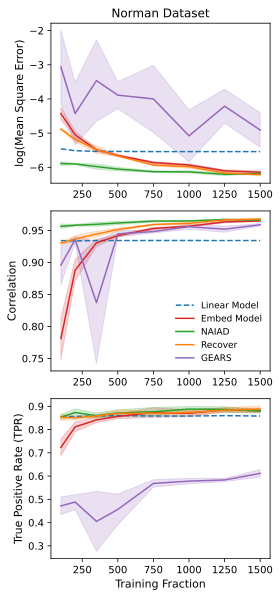

In [20]:
n_tpr = 200
df['test_tpr'] = df[f'test_tpr{n_tpr}']
df['train_loss'] = np.log(df['train_loss'])
df['val_loss'] = np.log(df['val_loss'])
df['test_loss'] = np.log(df['test_loss'])

plt_ax = {'test_loss': {'title': 'Test Loss',
                          'y': 'log(Mean Square Error)'},
          'test_corr': {'title': 'Test Correlation',
                          'y': 'Correlation'},
          'test_tpr': {'title': 'Test TPR',
                          'y': 'True Positive Rate (TPR)'}}

fig, axs = plt.subplots(len(plt_ax), 1, figsize = [4, 8])
for i, y_ax in enumerate(plt_ax):
    ax = axs[i]
    sns.lineplot(df[(df['model_type'] == 'linear')], x = 'n_train', y = y_ax, label = 'Linear Model', linestyle = '--', errorbar = None, ax = ax)
        
    sns.lineplot(df[(df['model_type'] == 'embed')], 
                 x = 'n_train', y = y_ax, 
                 label = f'Embed Model', 
                 errorbar = 'se', 
                 color = '#d62728',
                 ax = ax)
        
    sns.lineplot(df[(df['model_type'] == 'both')], 
                 x = 'n_train', y = y_ax, 
                 label = f'NAIAD', 
                 errorbar = 'se', 
                 color = '#2ca02c',
                 ax = ax)
    
    sns.lineplot(df[(df['model_type'] == 'recover')], 
                 x = 'n_train', y = y_ax, 
                 label = f'Recover', 
                 errorbar = 'se', 
                 color = '#ff7f0e',
                 ax = ax)
                
    sns.lineplot(df[df['model_type'] == 'gears'],
                 x = 'n_train', y = y_ax, 
                 label = f'GEARS', 
                 errorbar = 'se', 
                 color = '#9467bd',
                 ax = ax)
        
    ax.set_ylabel(plt_ax[y_ax]['y'], fontsize=11)
    ax.set_xlabel('')

fig.tight_layout()
axs[0].set_title(f'{data_source.replace("_", " ").title()} Dataset')
axs[0].get_legend().remove()
axs[1].legend(fontsize=9, frameon=False)
axs[2].get_legend().remove()
axs[2].set_xlabel('Training Fraction', fontsize=11)